In [1]:
# junk for jupyter notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The imports below are fairly standard for my work - I just copy and paste them into a new notebook, generally.

All my personal tools (ncdiag, gmao_tools, simple_obsplot) can be accessed here:
    https://github.com/will-mccarty/das_tools/tree/master/python_tools



In [2]:
#standard imports (I just copy and paste this into most notebooks)
import numpy as np
import matplotlib.pyplot as plt
import gmao_tools as gt
import matplotlib
#font = {'family' : 'normal',
#        'size'   : 18}

#matplotlib.rc('font', **font)

import simple_obsplot as sop
import cartopy.crs as ccrs

import ioda
import ioda_access as ia

This is a pretty basic walk-through of the `ioda_access.py` module.  It really isn't anything fancy, but it's how I interact with ioda files.  It is effectively a fork of `ncdiag.py`, which is how I underact with GSI netcdf diag files.  

Hopefully, this serves as a use case of where power users need direct access to the data.  This isn't a one-size-fits-all plotting package.  Some of my plotting examples here are just shortcut routines.  

In all practical purposes, this intermediate level of interfacing with the data could also be used to generate customizable plots and tools that could be propagated upward to the GUI-level.

OK - Let's open a single file

In [3]:
fn = '/discover/nobackup/drholdaw/JediEwok/R2D2DataStore/Local/geos/diag/a002/PT6H/2020-12-14/geos.a002.diag.PT6H.aircraft.2020-12-14T21:00:00Z.PT6H.nc4'
acft_file = ia.obs(fn)

Note:  You'll see that the timestamp is 2100 UTC.  That's a GMAO nuance related to our Incremental Analysis Update (IAU) initialization procedure.  2100 is equivalent to a 0000 UTC analysis.

The way I have this implemented, you need to set the variable up front.  This makes it easy to switch between variables, but more importantly, it allows variables to be generalized internal to `ioda_access.py`.

In [4]:
obs_variable = 'air_temperature'
acft_file.set_obs_var(obs_variable)

For a lot of these examples, I'm going to use a 'simple_obsplot' module, which is really just a few plotting shortcuts/routines.  FOr example, `plot_obs_map` really just plots lon v. lat on a cartopy projection.  Nothing fancy.

The plot below shows all the data in this one RO file

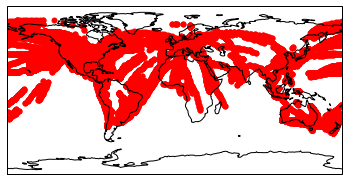

In [5]:
sop.plot_obs_map(acft_file)

OK - now we want to plot the ASDAR data, which has an `Observation_Type` of 131.  Here, we can use the mask feature, which just uses a string of logic to 'select' the data.  

Note:  It would have been more proper to call this a select routine than a mask routine, as it returns values that match the logical string (all data points that are `True` )

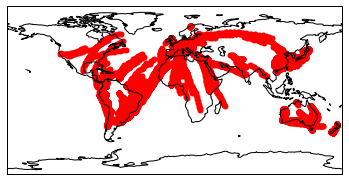

In [6]:
msk = '(ObsType/air_temperature == 131)'
acft_file.set_mask(msk)
acft_file.use_mask(True)
sop.plot_obs_map(acft_file)

I'm lazy; typing `Observation_Type` is very tedious.  At GMAO, we use the shorthand `kx`, which is also used in places within the GSI.  Within the `ioda_access` module, I made a quick shortcut dictionary that allows shorthand:

```
varmap = {
    'lat':   'MetaData/latitude'         ,
    'lon':   'MetaData/longitude'        ,
    'kx':     'ObsType/OBSVAR' ,
    'subtype':'Observation_Subtype',
    'sigo':   'EffectiveError/OBSVAR',
    'used':  'EffectiveQC/OBSVAR',
    'gsiused': 'GsiUseFlag/OBSVAR',
    ...
    } 
```

Note - `OBSVAR` is the template for the variable defined in `ia.set_obs.var()` above.  

So this is equivalent:

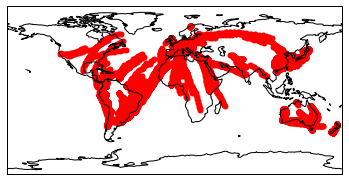

In [7]:
msk = '(kx == 131)'
acft_file.set_mask(msk)
acft_file.use_mask(True)
sop.plot_obs_map(acft_file)

Let's see how many COSMIC-2 data lower than 500 hPa that were `used` in the GSI:

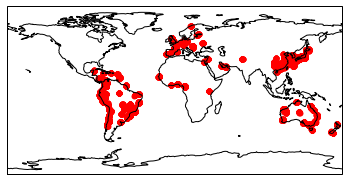

In [8]:
msk = '(kx == 131) & (pres > 50000) & (gsiused == 1)'
acft_file.set_mask(msk)
acft_file.use_mask(True)
sop.plot_obs_map(acft_file)

Let's plot a quick histogram of O-B for the data between 200 & 300 hPa, assimilated or rejected.

Note:  At GMAO, the O-F (obs minus forecast) nomenclature dominates, so I tend to use O-B and O-F interchangably

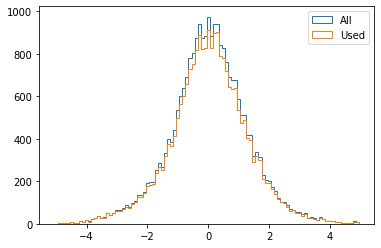

In [9]:
msk = '(kx >= 131) & (pres >= 20000) & (pres <= 30000)'
acft_file.set_mask(msk)

cur_omf = acft_file.v('omf')  # a long vector containing the omf values
bins = gt.bins(-5,5,0.1) # a simple routine I have to define bins by min/max/size

h = plt.hist(cur_omf,bins=bins,label='All',histtype='step')

msk = '(kx >= 131) & (pres >= 20000) & (pres <= 30000) & (gsiused == 1)'
acft_file.set_mask(msk)

cur_omf = acft_file.v('omf')  # a long vector containing the omf values

h = plt.hist(cur_omf,bins=bins,label='Used',histtype='step')

plt.legend()
plt.show()

I've also wired in the ability to do derived calculations.  For example in IODA, we only have 'O' & 'B', so we must calculate O-B.  I have a `derived_var` dictionary that treats calculations as variables within the file:

```
derived_var = {
    'omf':         {'func': iof.omf,          'deps': ['ObsValue/OBSVAR','hofx/OBSVAR']},
    'gsiomfbc':    {'func': iof.gsiomfbc,     'deps': ['ObsValue/OBSVAR','GsiHofXBc/OBSVAR']},
    'gsiomfnbc':    {'func': iof.gsiomfnbc,     'deps': ['ObsValue/OBSVAR','GsiHofX/OBSVAR']},
    }
```

So let's plot the JEDI/hofx O-B `omf` & the GSI O-B `gsiomfbc` histogram for all used (in GSI) observations:


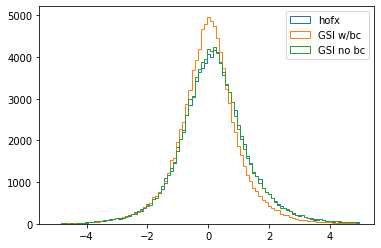

In [10]:
msk = '(kx >= 131) & (gsiused == 1)'
acft_file.set_mask(msk)

bins = gt.bins(-5,5,0.1) # a simple routine I have to define bins by min/max/size

h = plt.hist(acft_file.v('omf'),
             bins=bins,label='hofx',histtype='step')

h = plt.hist(acft_file.v('gsiomfbc'),
             bins=bins,label='GSI w/bc',histtype='step')

h = plt.hist(acft_file.v('gsiomfnbc'),
             bins=bins,label='GSI no bc',histtype='step')

plt.legend()
plt.show()

In all reality, I don't often look at one file at a time, but rather some timeseries of files...

I've created an `obs_template` class, which is basically on top of `obs`.  As an input, it takes a templated string, a startdate, and an enddate.

In [11]:
startdate=2020112303
enddate=2020112321

fn_template = '/discover/nobackup/drholdaw/JediEwok/R2D2DataStore/Shared/ncdiag/ob/x0044/PT6H/${yyyy}-${mm}-${dd}/ncdiag.x0044.ob.PT6H.aircraft.${yyyy}-${mm}-${dd}T${hh}:00:00Z.nc4'
acft_tmpl = ia.obs_template(fn_template,startdate=startdate,enddate=enddate)

acft_tmpl.set_obs_var('air_temperature')

Otherwise, the usage is the same.  Let's plot all of the ASDAR data

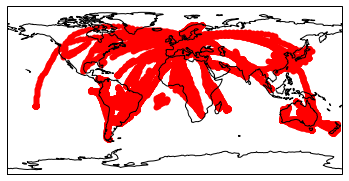

In [12]:
msk = '(kx == 131)'
acft_tmpl.set_mask(msk)
acft_tmpl.use_mask(True)
sop.plot_obs_map(acft_tmpl)

Finally, some stats.  Again, the derived stats are defined in a dictionary:

```
stats = {
    'mean':        {'func': np.mean,          'deps': None} ,
    'absmean':     {'func': iof.absmean,      'deps': None} ,
    'std':         {'func': np.std,           'deps': None} ,
    'count':       {'func': len,              'deps': None} ,
    'sum':         {'func': np.sum,           'deps': None} ,
    'cpen':        {'func': iof.cpen,         'deps': ['sigo']} ,
    'rms':         {'func': iof.rms,          'deps': None} }
```

You can either get the bulk stat:

In [13]:
print('obs mean: ',
      acft_tmpl.stat('mean','obs'))

obs mean:  261.75555


Or the timeseries:

In [14]:
print('obs mean timeseries: ')
dates, vals = acft_tmpl.stat_ts('mean','obs')
print('  dates: ',dates)
print('  vals: ', vals)

print('\n or by dataframe....')
df = acft_tmpl.stat_ts('mean','obs',DataFrame=True)
df

obs mean timeseries: 
  dates:  [2020112303 2020112309 2020112315 2020112321]
  vals:  [260.2727  261.1854  261.35397 264.31198]

 or by dataframe....


,ndate,Val,datetime
0,2020112303,260.272705,2020-11-23 03:00:00
1,2020112309,261.185394,2020-11-23 09:00:00
2,2020112315,261.353973,2020-11-23 15:00:00
3,2020112321,264.311981,2020-11-23 21:00:00
